In [53]:
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.ERROR)

In [1]:
import os
import talib
import sqlite3
import requests
import numpy as np
import pandas as pd
import dateparser as dp
from binance.client import Client
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20,5]

In [2]:
intervals = ['1m','3m','5m','15m','30m','1h','2h','4h','6h','8h','12h','1d','3d']

In [3]:
def get_ohlc_binance(symbol='ethbtc',start_date='30 days ago',interval='1d',indicators=None):
    client = Client('','')
    ohlc = client.get_historical_klines(symbol.upper(),interval,start_date,)         
    if ohlc and len(ohlc) > 0:
        date = [pd.to_datetime(i[0], unit='ms') for i in ohlc]
        _open = [float(i[1]) for i in ohlc]
        _high = [float(i[2]) for i in ohlc]
        _low = [float(i[3]) for i in ohlc]
        _close = [float(i[4]) for i in ohlc]
        _volume = [float(i[5]) for i in ohlc]
        sym = [symbol.lower()]*len(_close)
        df = pd.DataFrame({'symbol':sym,'date':date,'open':_open,'high':_high,'low':_low,'close':_close,'volume':_volume})
        if indicators:
            df = indicators(df)
        return df
    return None

In [4]:
def get_ohlc_tiingo(symbol='ethbtc',start_date='30 days ago',interval='1d',indicators=None):
    # @param:interval This allows you to set the frequency in which you want data resampled. 
    # For example "1hour" would return the data where OHLC is calculated on an hourly schedule. 
    # The minimum value is "1min". 
    # Units in minutes (min), hours (hour), and days (day) are accepted.
    # Format is # + (min/hour/day)
    if 'm' in interval and not 'min' in interval:
        interval = interval.replace('m','min')
    if 'h' in interval and not 'hour' in interval:
        interval = interval.replace('h','hour')
    if 'd' in interval and not 'day' in interval:
        interval = interval.replace('d','day')        
    assert('min' in interval or 'hour' in interval or 'day' in interval)
    
    TOKEN = os.getenv('TIINGO_API_TOKEN')
    startDate = dp.parse(start_date).strftime('%Y-%m-%d')
    # https://api.tiingo.com/docs/crypto
    url = "https://api.tiingo.com/tiingo/crypto/prices?tickers={}&resampleFreq={}&startDate={}&token={}".format(symbol,interval,startDate,TOKEN)
    data = requests.get(url).json()
    d,o,h,l,c,v = [],[],[],[],[],[]
    if len(data):
        for bar in data[0]['priceData']:
            d.append(dp.parse(bar['date']))
            o.append(bar['open'])
            h.append(bar['high'])
            l.append(bar['low'])
            c.append(bar['close'])
            v.append(bar['volumeNotional']) # close * volume in quote currency
            
        df = pd.DataFrame({'symbol':symbol, 'date': d, 'open':o, 'high':h, 'low':l, 'close':c, 'volume':v})
        if indicators:
            df = indicators(df)

        return df
    return None

In [5]:
def get_ohlc(exchange='binance',symbol='ethbtc',start_date='30 days ago',interval='1day',indicators=None):
    ohlc = None
    if exchange=='binance':
        ohlc = get_ohlc_binance(symbol,start_date,interval,indicators)
    elif exchange=='tiingo':
        ohlc = get_ohlc_tiingo(symbol,start_date,interval,indicators)
    return ohlc

In [6]:
def get_syms_binance(market='btc'):
    exchange_info = requests.get("https://api.binance.com/api/v1/exchangeInfo").json()
    return filter(None,[e['symbol'].lower() if e['quoteAsset']==market.upper() else '' for e in exchange_info['symbols']])

In [7]:
def get_syms_tiingo(market='btc'):
    TOKEN = os.getenv('TIINGO_API_TOKEN')
    meta = requests.get("https://api.tiingo.com/tiingo/crypto?token={}".format(TOKEN)).json()
    return [item['ticker'] for item in meta if item["quoteCurrency"] == market]

In [8]:
def get_syms(exchange='binance',market='btc'):
    syms = []
    if exchange=='binance':
        syms = get_syms_binance(market)
    elif exchange=='tiingo':
        syms = get_syms_tiingo(market)
    return syms

In [26]:
def get_market(exchange='binance',market='usd',start_date='1 year ago',interval='1day',indicators=None):
    syms = get_syms(exchange,market)
    data = []
    for sym in syms:
        df = get_ohlc(exchange,sym,start_date,interval,indicators)
        if df is not None:
            df['market'] = market
            data.append(df)
    df = pd.concat(data,ignore_index=True)
    df['date'] = df.date.apply(lambda d: d.replace(tzinfo=None))
    return df

In [18]:
def get_markets(exchange='binance',markets=['usd','eth','btc'],start_date='1 year ago',interval='1day'):
    data = []
    for market in markets:
        df = get_market(exchange=exchange,market=market,start_date=start_date,interval=interval)
        if len(df):
            data.append(df)
    df = pd.concat(data,ignore_index=True)
    return df

In [19]:
def to_sql(df,name='tiingo'):
    conn = sqlite3.connect(name+'.db')
    df.to_sql(name, conn, if_exists="replace")

In [20]:
def read_sql(name='tiingo'):
    conn = sqlite3.connect(name+'.db')
    df = pd.read_sql_query("select * from {};".format(name), conn)    
    return df

In [21]:
def to_pickle(df,name='tiingo'):
    df.to_pickle(name+'.pickle')

In [22]:
def read_pickle(name='tiingo'):
    df = pd.read_pickle(name+'.pickle')
    return df

In [272]:
df = get_markets(exchange='tiingo',markets=['btc'],start_date='1 year ago',interval='1d')
to_pickle(df,'btc_tiingo_1d')
df = read_pickle('btc_tiingo_1d')

2018-02-18 15:17:05,363 Starting new HTTPS connection (1): api.tiingo.com
2018-02-18 15:17:06,191 https://api.tiingo.com:443 "GET /tiingo/crypto?token=4cbc53fef0f4c483aa882437253dd3a878191788 HTTP/1.1" 200 246846
2018-02-18 15:17:06,723 Starting new HTTPS connection (1): api.tiingo.com
2018-02-18 15:17:08,150 https://api.tiingo.com:443 "GET /tiingo/crypto/prices?tickers=pinkbtc&resampleFreq=1day&startDate=2017-02-18&token=4cbc53fef0f4c483aa882437253dd3a878191788 HTTP/1.1" 200 79654
2018-02-18 15:17:09,111 Starting new HTTPS connection (1): api.tiingo.com
2018-02-18 15:17:11,623 https://api.tiingo.com:443 "GET /tiingo/crypto/prices?tickers=xrpbtc&resampleFreq=1day&startDate=2017-02-18&token=4cbc53fef0f4c483aa882437253dd3a878191788 HTTP/1.1" 200 82765
2018-02-18 15:17:12,436 Starting new HTTPS connection (1): api.tiingo.com
2018-02-18 15:17:13,168 https://api.tiingo.com:443 "GET /tiingo/crypto/prices?tickers=postbtc&resampleFreq=1day&startDate=2017-02-18&token=4cbc53fef0f4c483aa882437253

In [226]:
%ls *.pickle

btc_binance_1hour.pickle  btc_tiingo_4hour.pickle   usd_tiingo_1d.pickle
btc_tiingo_1day.pickle    usd_binance_4hour.pickle


In [273]:
df.symbol.unique()

array([u'pinkbtc', u'xrpbtc', u'postbtc', u'hbnbtc', u'mnabtc', u'nulsbtc',
       u'bitbbtc', u'inbtc', u'conbtc', u'qwarkbtc', u'chessbtc',
       u'xbcbtc', u'phobtc', u'bopbtc', u'rbtbtc', u'arcbtc', u'kbrbtc',
       u'xcrebtc', u'matrxbtc', u'mtlbtc', u'trustbtc', u'athbtc',
       u'mlitebtc', u'ttybtc', u'omnibtc', u'evrbtc', u'mdabtc', u'aebtc',
       u'manabtc', u'enjbtc', u'leabtc', u'crxbtc', u'xctbtc', u'mstbtc',
       u'evobtc', u'brobtc', u'enrgbtc', u'yywbtc', u'ntrnbtc', u'wabibtc',
       u'dashbtc', u'frcbtc', u'deusbtc', u'toabtc', u'ixcbtc', u'mecbtc',
       u'luxbtc', u'gamebtc', u'korebtc', u'sagabtc', u'sdrnbtc',
       u'smcbtc', u'slrbtc', u'bucksbtc', u'rlcbtc', u'muebtc', u'mcobtc',
       u'kmdbtc', u'cannbtc', u'drpbtc', u'hucbtc', u'prlbtc', u'tajbtc',
       u'xelbtc', u'nxtbtc', u'moinbtc', u'aionbtc', u'bplbtc', u'mnmbtc',
       u'plrbtc', u'ostbtc', u'bernbtc', u'copperbtc', u'snglsbtc',
       u'ecobbtc', u'havbtc', u'arkbtc', u'motobtc', u'dalcb

In [51]:
top = ['ethbtc','xrpbtc','bchbtc','ltcbtc','adabtc','neobtc','xlmbtc','eosbtc','miotabtc','dashbtc','xlmbtc','xmrbtc']

In [184]:
 df3 = df2.resample('1w').agg('last')

In [277]:
#df2 = pd.pivot_table(df.loc[df['symbol'].isin(top)], values='close', index=['date'],columns=['symbol']).fillna(method='bfill')
df2 = pd.pivot_table(df, values='close', index=['date'],columns=['symbol']).fillna(method='bfill')

In [278]:
(df2 / df2.iloc[0,:]).tail()

symbol,1337btc,1stbtc,21mbtc,2givebtc,300btc,42btc,611btc,808btc,888btc,8bitbtc,...,zapbtc,zclbtc,zecbtc,zeitbtc,zenbtc,zerbtc,zetbtc,zoibtc,zrxbtc,zsebtc
date,,,,,,,,,,,,,,,,,,,,,
2018-02-14,0.833333,0.133095,0.434619,3.315789,0.567320,15.293974,1.324143,2.0,3.695652,2.428004,...,0.759472,30.433694,1.755875,2.0,0.603604,3.113158,0.566502,1085.083333,1.006517,0.0363
2018-02-15,0.666667,0.122667,0.427399,3.315789,0.568706,11.191395,1.301000,2.0,3.565217,2.424028,...,0.616054,27.241673,1.643058,2.0,0.610622,3.144561,0.502463,984.000000,1.201842,0.0316
2018-02-16,0.500000,0.126429,0.397132,3.289474,0.513054,13.243154,1.333429,1.0,3.565217,2.421378,...,0.701656,27.778023,1.619306,1.0,0.625874,3.158070,0.527094,967.250000,1.123579,0.0332
2018-02-17,0.666667,0.123857,0.454995,3.157895,0.413726,13.261843,1.355857,2.0,3.391304,1.965548,...,0.704463,30.139135,1.522058,2.0,0.582895,3.017368,0.532020,903.000000,1.029167,0.0313
2018-02-18,0.666667,0.116524,0.430465,3.000000,0.490195,12.963366,1.331286,2.0,3.391304,2.101590,...,0.643278,29.546031,1.473479,1.0,0.588811,2.982456,0.482759,844.916667,0.971909,0.0316


In [299]:
#result = algos.OLMAR.run_combination(df2, window=[3,5,10,15], eps=10)
#result = algos.OLMAR.run_combination(df2, window=3, eps=10)
#algo = algos.DynamicCRP(n=52, min_history=8)
#result = algos.PAMR.run_combination(df2, eps=0.025)
#result.fee = 0.0025
test = df2.loc['2017-06-01':'2017-08-30']
#algo = algos.Anticor()
#algo = algos.BAH()
#algo = algos.BCRP()
#algo = algos.BNN()
#algo = algos.CORN()
#algo = algos.CRP()
#+ algo = algos.CWMR()
#algo = algos.EG()
#algo = algos.Kelly()
#algo = algos.OLMAR()
#algo = algos.ONS()
#algo = algos.PAMR()
#algo = algos.RMR()
#algo = algos.UP()
#algo = algos.DynamicCRP(n=52, min_history=8)
algo = algos.BestSoFar(n=10,metric='sharpe')
#algo = algos.BestSoFar()

list_result = algo.run(test)
list_result.fee = 0.0025
print(list_result.summary())
list_result.plot(figsize=(16,16))

2018-02-18 15:44:08,715 Running BestSoFar...


ZeroDivisionError: ('float division by zero', u'occurred at index 1337btc')

In [256]:
%ls *.pickle

btc_binance_1hour.pickle  btc_tiingo_4hour.pickle   usd_tiingo_1d.pickle
btc_tiingo_1day.pickle    usd_binance_4hour.pickle


In [281]:
df2.loc['2018':]

symbol,1337btc,1stbtc,21mbtc,2givebtc,300btc,42btc,611btc,808btc,888btc,8bitbtc,...,zapbtc,zclbtc,zecbtc,zeitbtc,zenbtc,zerbtc,zetbtc,zoibtc,zrxbtc,zsebtc
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,6.000000e-08,0.000071,0.000015,0.000002,0.040555,3.555000,0.000024,5.000000e-08,5.000000e-07,0.000039,...,0.000014,0.007550,0.038343,1.000000e-08,0.004101,0.000253,6.800000e-07,0.000155,0.000066,0.000003
2018-01-02,6.000000e-08,0.000085,0.000013,0.000002,0.045000,3.555000,0.000026,5.000000e-08,4.900000e-07,0.000045,...,0.000011,0.006331,0.037039,1.000000e-08,0.003510,0.000230,8.600000e-07,0.000222,0.000060,0.000003
2018-01-03,6.000000e-08,0.000117,0.000024,0.000001,0.045000,3.555000,0.000064,5.000000e-08,5.100000e-07,0.000046,...,0.000011,0.007101,0.037089,1.000000e-08,0.003335,0.000303,9.700000e-07,0.000164,0.000066,0.000003
2018-01-04,6.000000e-08,0.000112,0.000014,0.000002,0.036295,3.224534,0.000045,5.000000e-08,4.700000e-07,0.000042,...,0.000010,0.006517,0.036199,1.000000e-08,0.003620,0.000285,1.200000e-06,0.000149,0.000069,0.000004
2018-01-05,6.000000e-08,0.000097,0.000015,0.000001,0.045000,3.170000,0.000052,5.000000e-08,5.700000e-07,0.000046,...,0.000022,0.007305,0.032759,1.000000e-08,0.002722,0.000345,9.800000e-07,0.000122,0.000069,0.000004
2018-01-06,6.000000e-08,0.000115,0.000018,0.000002,0.038500,3.102000,0.000042,5.000000e-08,6.200000e-07,0.000050,...,0.000037,0.011229,0.038092,1.000000e-08,0.003109,0.000411,1.190000e-06,0.000153,0.000081,0.000004
2018-01-07,6.000000e-08,0.000115,0.000017,0.000002,0.043000,2.700000,0.000036,5.000000e-08,5.800000e-07,0.000056,...,0.000040,0.013930,0.046413,1.000000e-08,0.003210,0.000600,1.660000e-06,0.000177,0.000084,0.000004
2018-01-08,6.000000e-08,0.000136,0.000025,0.000002,0.045000,3.718500,0.000070,5.000000e-08,8.400000e-07,0.000100,...,0.000047,0.013011,0.046219,1.000000e-08,0.003372,0.000799,1.640000e-06,0.000168,0.000122,0.000004
2018-01-09,6.000000e-08,0.000139,0.000067,0.000002,0.045000,3.450000,0.000060,5.000000e-08,1.120000e-06,0.000084,...,0.000038,0.012051,0.046352,1.000000e-08,0.003960,0.000481,1.900000e-06,0.000160,0.000141,0.000004


In [380]:
ethbtc = pd.pivot_table(df[df.symbol=='ethbtc'], values='close', index=['date'],columns=['symbol'])
ethbtc = df[df.symbol=='ethbtc'].reset_index().close

In [381]:
def getTEvents(gRaw,h):
    tEvents,sPos,sNeg = [],0,0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos,sNeg = max(0,sPos+diff.iloc[i]),min(0,sNeg+diff.iloc[i])
        if sNeg < -h:
            sNeg = 0; tEvents.append(i)
        elif sPos > h:
            sPos = 0; tEvents.append(i)
            
    return tEvents

In [386]:
idx = getTEvents(df[df.symbol=='ethbtc'].reset_index().close,0.01)

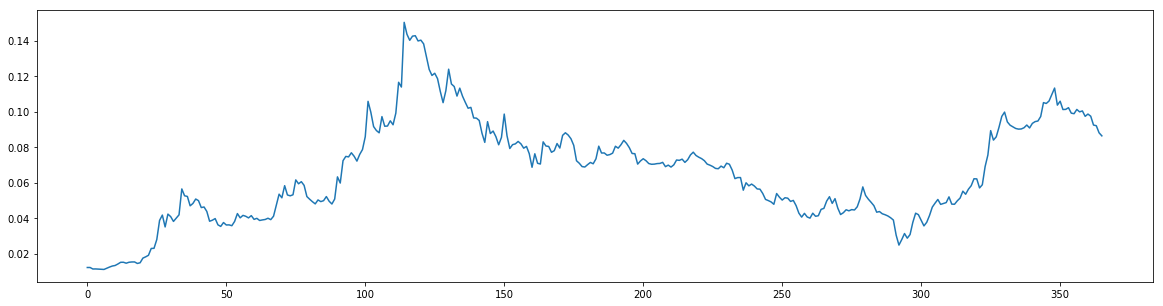

In [389]:
ethbtc.plot()

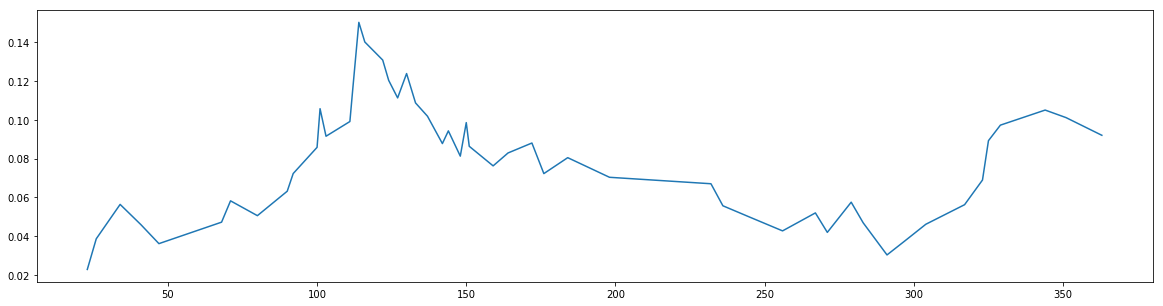

In [388]:
ethbtc[idx].plot()